In [2]:
!wget -nc --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar
!unrar x UCF50.rar -inul -y

--2021-08-21 05:34:55--  https://www.crcv.ucf.edu/data/UCF50.rar
Resolving www.crcv.ucf.edu (www.crcv.ucf.edu)... 132.170.214.127
Connecting to www.crcv.ucf.edu (www.crcv.ucf.edu)|132.170.214.127|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 3233554570 (3.0G) [application/rar]
Saving to: ‘UCF50.rar’

UCF50.rar           100%[===================>]   3.01G  40.5MB/s    in 76s     

2021-08-21 05:36:11 (40.8 MB/s) - ‘UCF50.rar’ saved [3233554570/3233554570]



In [32]:
import os
import cv2
import math
#import pafy
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from moviepy.editor import *
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [31]:
pip install --upgrade youtube-dl

     |████████████████████████████████| 1.9 MB 8.7 MB/s 


In [4]:
seed_constant = 23
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

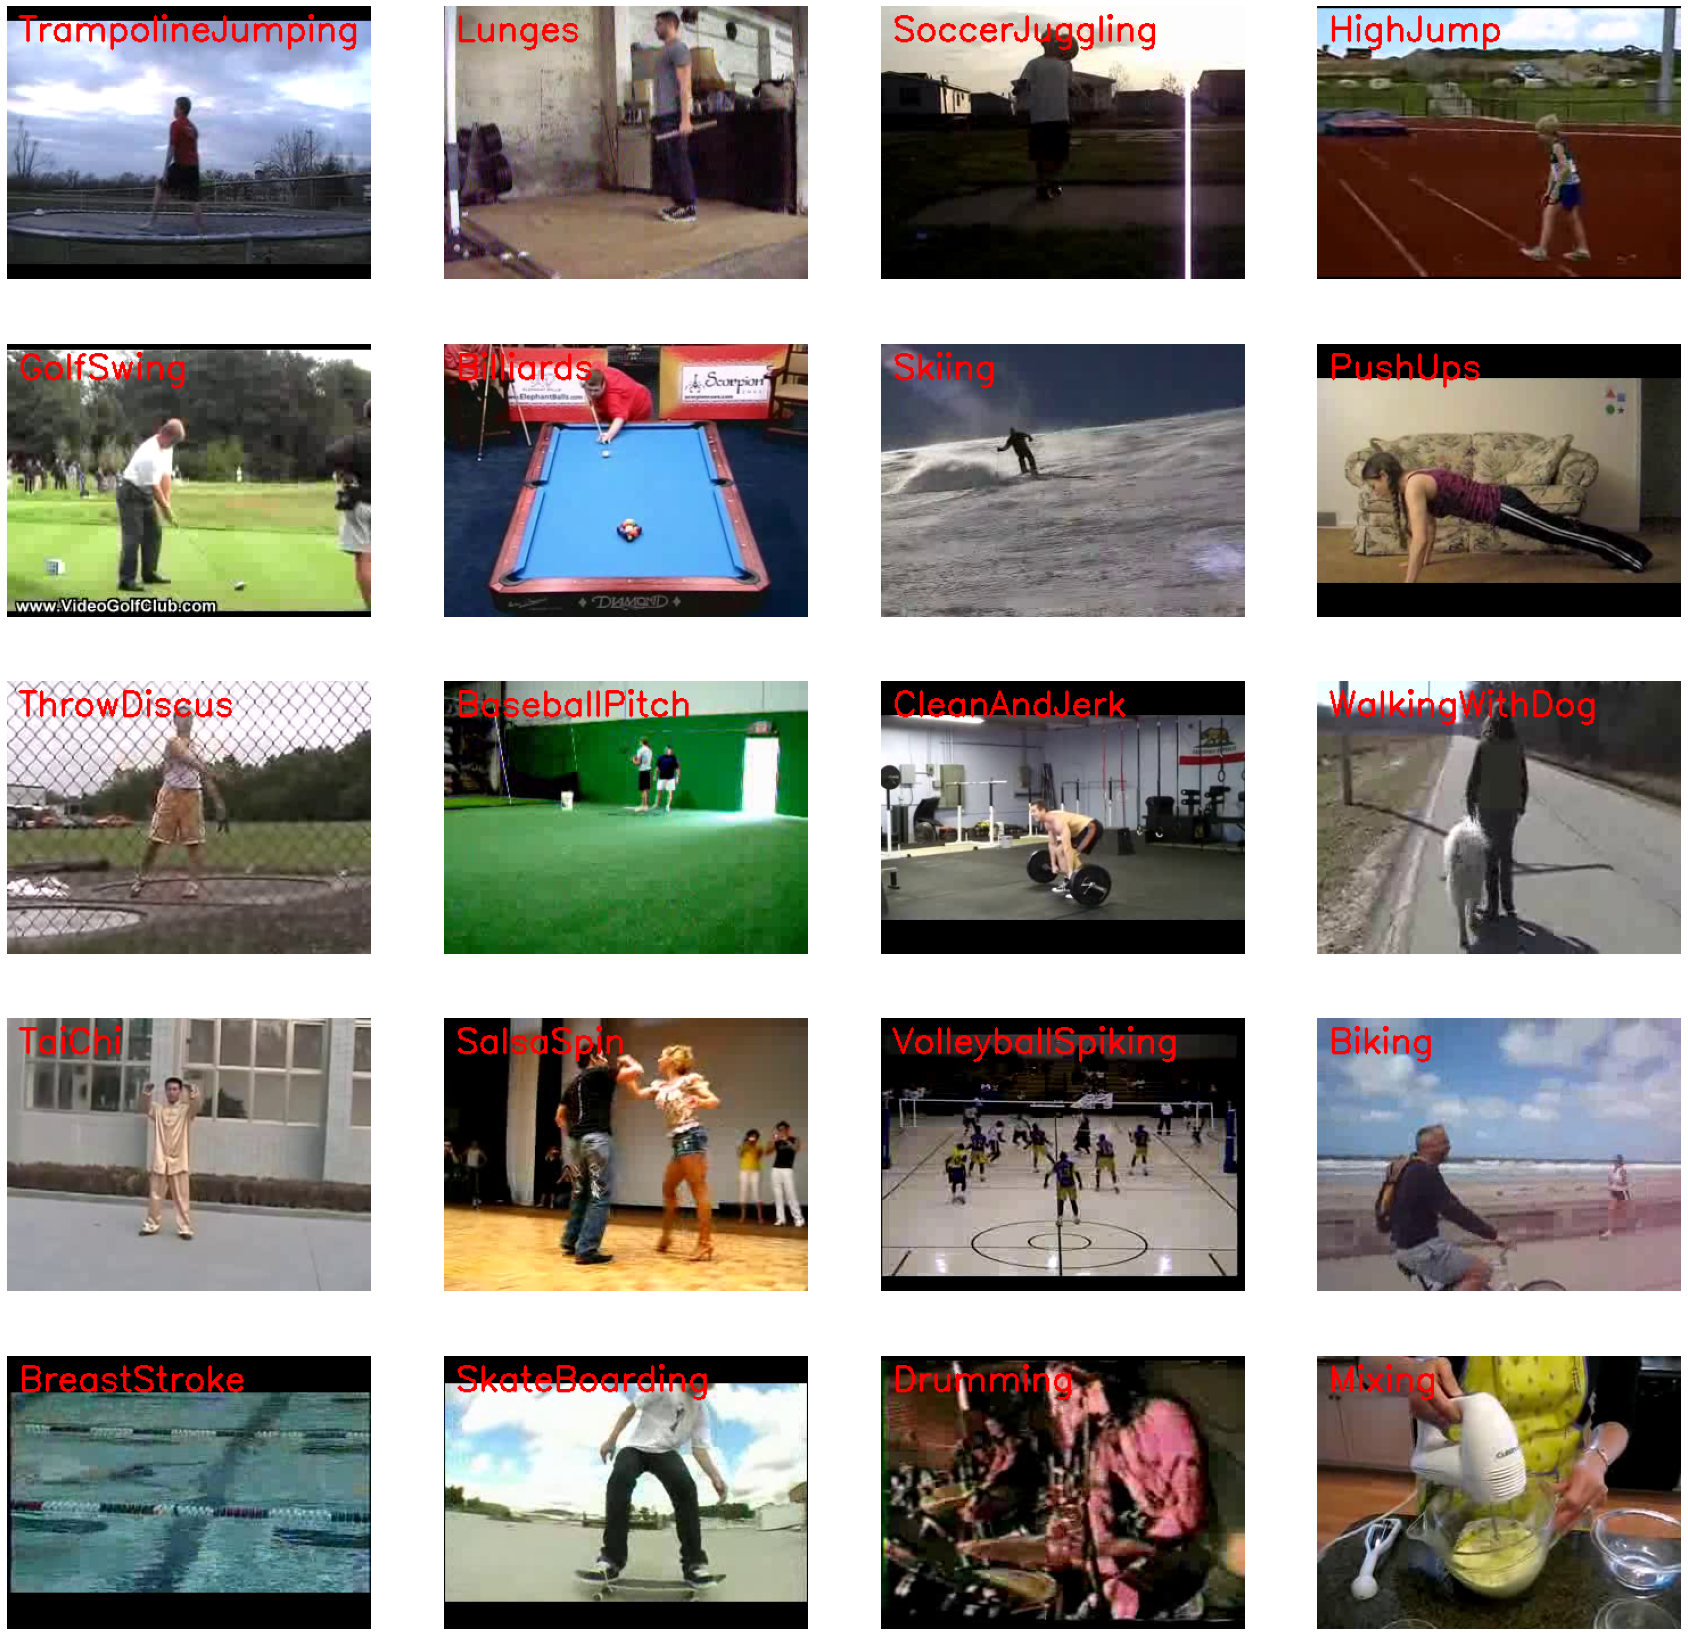

In [5]:
#Plotting the figure using Matplotlib
plt.figure(figsize=(30,30))
classes_name=os.listdir('UCF50')
random_r=random.sample(range(len(classes_name)),20)

for i,j in enumerate(random_r,1):
  selected_class=classes_name[j]
  video_files=os.listdir(f'UCF50/{selected_class}')
  selected_video=random.choice(video_files)
  video_reader=cv2.VideoCapture(f'UCF50/{selected_class}/{selected_video}')
  _,bgr=video_reader.read()
  video_reader.release()
  rgb=cv2.cvtColor(bgr,cv2.COLOR_BGR2RGB)
  cv2.putText(rgb,selected_class,(10,30),cv2.FONT_HERSHEY_SIMPLEX,1,(255,0,0),2)
  plt.subplot(5,4,i)
  plt.imshow(rgb)
  plt.axis("off")

In [6]:
image_height, image_width = 64, 64
max_images_per_class = 8000

dataset_directory = "UCF50"
classes_list = ["WalkingWithDog", "TaiChi", "Swing", "HorseRace"]

model_output_size = len(classes_list)

In [7]:
def frames_extraction(video_path):
    frames_list = []
    
    # Reading the Video File Using the VideoCapture
    video_reader = cv2.VideoCapture(video_path)

    # Iterating through Video Frames
    while True:

        # Reading a frame from the video file 
        success, frame = video_reader.read() 

        # If Video frame was not successfully read then break the loop
        if not success:
            break

        # Resize 
        resized_frame = cv2.resize(frame, (image_height, image_width))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
        
        # Appending the normalized frame into the frames list
        frames_list.append(normalized_frame)
    
    video_reader.release()

    return frames_list

In [8]:
def create_dataset():
    temp_features = [] 
    features = []
    labels = []

    for class_index, class_name in enumerate(classes_list):
        print(f'Extracting Data of Class: {class_name}')
        
        files_list = os.listdir(os.path.join(dataset_directory, class_name))

        # Iterating through all the files present in the files list
        for file_name in files_list:

            # Construct the complete video path
            video_file_path = os.path.join(dataset_directory, class_name, file_name)
            frames = frames_extraction(video_file_path)
            temp_features.extend(frames)
      
        features.extend(random.sample(temp_features, max_images_per_class))

        labels.extend([class_index] * max_images_per_class)
        
        temp_features.clear()

    features = np.asarray(features)
    labels = np.array(labels)  

    return features, labels

In [9]:
features, labels = create_dataset()

Extracting Data of Class: WalkingWithDog
Extracting Data of Class: TaiChi
Extracting Data of Class: Swing
Extracting Data of Class: HorseRace


In [10]:
one_hot_encoded_labels = to_categorical(labels)

In [11]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.2, shuffle = True, random_state = seed_constant)

In [12]:

def create_model():

    # We will use a Sequential model for model construction
    model = Sequential()

    # Defining The Model Architecture
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', input_shape = (image_height, image_width, 3)))
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(model_output_size, activation = 'softmax'))

    # Printing the models summary
    model.summary()

    return model


# Calling the create_model method
model = create_model()

print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 60, 60, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 64)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 256)               16640     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1

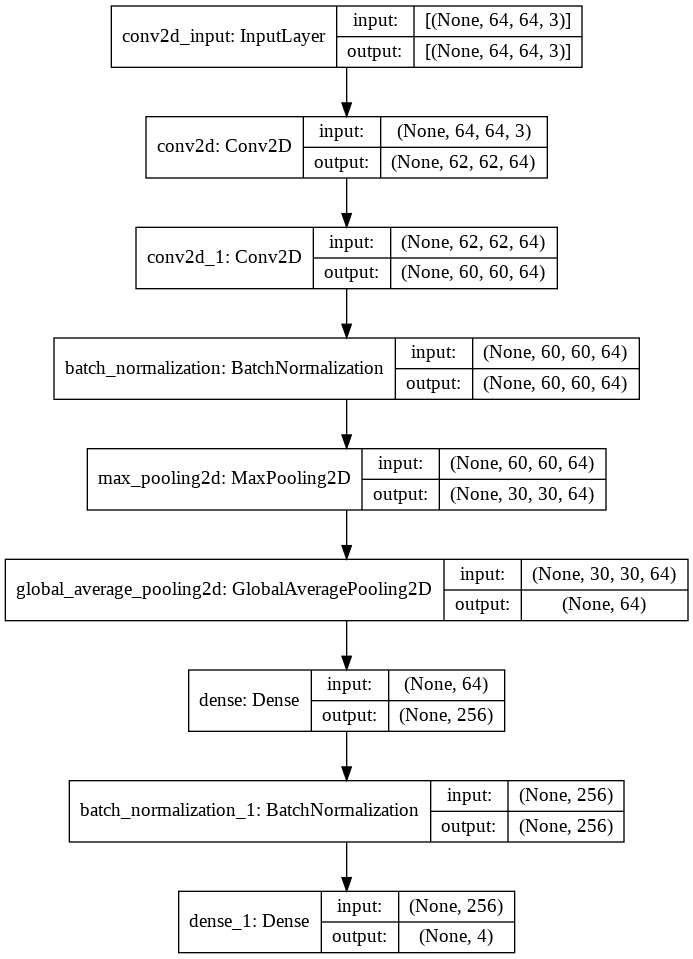

In [13]:
plot_model(model, to_file = 'model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [14]:
# Adding Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

# Adding loss, optimizer and metrics values to the model.
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start Training
model_training_history = model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 4 , shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/50
5120/5120 [==============================] - 51s 4ms/step - loss: 0.9140 - accuracy: 0.6257 - val_loss: 1.6538 - val_accuracy: 0.6117
Epoch 2/50
5120/5120 [==============================] - 20s 4ms/step - loss: 0.5432 - accuracy: 0.7990 - val_loss: 1.2220 - val_accuracy: 0.6947
Epoch 3/50
5120/5120 [==============================] - 20s 4ms/step - loss: 0.4041 - accuracy: 0.8537 - val_loss: 0.2008 - val_accuracy: 0.9312
Epoch 4/50
5120/5120 [==============================] - 19s 4ms/step - loss: 0.3495 - accuracy: 0.8760 - val_loss: 0.1718 - val_accuracy: 0.9523
Epoch 5/50
5120/5120 [==============================] - 19s 4ms/step - loss: 0.2948 - accuracy: 0.8980 - val_loss: 1.1076 - val_accuracy: 0.7369
Epoch 6/50
5120/5120 [==============================] - 19s 4ms/step - loss: 0.2525 - accuracy: 0.9134 - val_loss: 0.2233 - val_accuracy: 0.9355
Epoch 7/50
5120/5120 [==============================] - 19s 4ms/step - loss: 0.2458 - accuracy: 0.9184 - val_loss: 0.9794 - val_ac

In [15]:
model_evaluation_history = model.evaluate(features_test, labels_test)


200/200 [==============================] - 1s 5ms/step - loss: 0.1062 - accuracy: 0.9881


In [16]:

date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history
model_name = f'Model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Saving  Model
model.save(model_name)

In [17]:
def plot_metric(metric_name_1, metric_name_2, plot_name):
  # Get Metric values using metric names as identifiers
  metric_value_1 = model_training_history.history[metric_name_1]
  metric_value_2 = model_training_history.history[metric_name_2]


  epochs = range(len(metric_value_1))
  
  plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
  plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)
  

  plt.title(str(plot_name))
  plt.legend()

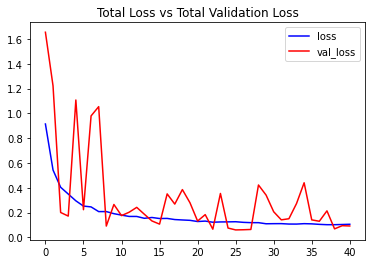

In [18]:
plot_metric('loss', 'val_loss', 'Total Loss vs Total Validation Loss')


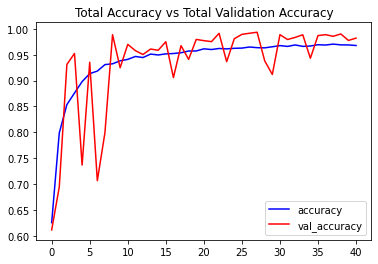

In [33]:
plot_metric('accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')
import pafy

In [35]:
def download_youtube_videos(youtube_video_url, output_directory):
    
    video = pafy.new(youtube_video_url)
    video_best = video.getbest()

    # Constructing the Output File Path
    output_file_path = f'{output_directory}/{video.title}.mp4'
    video_best.download(filepath = output_file_path, quiet = True)
    return video.title

In [39]:
def predict_on_live_video(video_file_path, output_file_path, window_size):

    predicted_labels_probabilities_deque = deque(maxlen = window_size)

    video_reader = cv2.VideoCapture(video_file_path)

    # Getting the width and height of the video 
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'), 24, (original_video_width, original_video_height))

    while True: 

        # Reading The Frame
        status, frame = video_reader.read() 

        if not status:
            break

        resized_frame = cv2.resize(frame, (image_height, image_width))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        predicted_labels_probabilities = model.predict(np.expand_dims(normalized_frame, axis = 0))[0]

        # Appending predicted label probabilities to the deque object
        predicted_labels_probabilities_deque.append(predicted_labels_probabilities)
        if len(predicted_labels_probabilities_deque) == window_size:

            # Converting Predicted Labels Probabilities Deque into Numpy array
            predicted_labels_probabilities_np = np.array(predicted_labels_probabilities_deque)
            predicted_labels_probabilities_averaged = predicted_labels_probabilities_np.mean(axis = 0)
            predicted_label = np.argmax(predicted_labels_probabilities_averaged)

            # Accessing The Class Name using predicted label.
            predicted_class_name = classes_list[predicted_label]
            cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
            #print(predicted_class_name)

        video_writer.write(frame)


        # cv2.imshow('Predicted Frames', frame)

        # key_pressed = cv2.waitKey(10)

        # if key_pressed == ord('q'):
        #     break

    # cv2.destroyAllWindows()

    
    # Closing the VideoCapture and VideoWriter objects and releasing all resources held by them. 
    video_reader.release()
    video_writer.release()

In [40]:
output_directory = 'Youtube_Videos'
os.makedirs(output_directory, exist_ok = True)
video_title = download_youtube_videos('https://www.youtube.com/watch?v=8u0qjmHIOcE', output_directory)
input_video_file_path = f'{output_directory}/{video_title}.mp4'

In [41]:
# Setting the Window Size which will be used by the Rolling Average Process
window_size = 25

output_video_file_path = f'{output_directory}/{video_title} -Output-WSize {window_size}.mp4'

predict_on_live_video(input_video_file_path, output_video_file_path, window_size)

VideoFileClip(output_video_file_path).ipython_display(width = 700)

100%|██████████| 866/866 [00:01<00:00, 773.66it/s]
